In [1]:
import os
from netCDF4 import Dataset
import netCDF4 as nc
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from scipy.interpolate import griddata
import matplotlib.ticker as mticker
from multiprocessing import Pool, cpu_count

In [2]:
# To use PLUMBER2_GPP_common_utils, change directory to where it exists
os.chdir('/g/data/w97/mm3972/scripts/Drought/Post_drought_rainfall')
from common_utils import *

# Check download issue

In [38]:
albedo_band   = "BSA_nir"
var_name      = "Albedo_"+albedo_band

scale_factor  = 0.001
missing_value = 32767

AWAP_5km_path = "/g/data/w97/mm3972/data/MODIS/MODIS_Albedo/AUS/regrid_2_AWAP_5km_daily/MCD43A3.061_500m_aid0001_"+albedo_band+"_2000-2024_albedo_regridded_daily.nc"
# AWAP_5km_path = "/g/data/w97/mm3972/data/MODIS/MODIS_Albedo/AUS/regrid_2_AWAP_5km/MCD43A3.061_500m_aid0001_BSA_nir_2015_albedo_regridded.nc"

In [ ]:
f_check_download = nc.Dataset(AWAP_5km_path,'r')
var_download     = f_check_download.variables[var_name]*scale_factor
var_download     = np.where(var_download > 1.0, np.nan, var_download)
var_download_mean= np.mean(var_download,axis=0)

In [ ]:
plt.imshow(var_download_mean)

# Check albedo data

### Parallally gap filling

In [3]:
import os
import gc
import argparse
import copy
import netCDF4 as nc
import numpy as np
from multiprocessing import Pool, cpu_count

def fill_gap_for_point(args):
    
    var_fill, lat, lon, window = args 
    
    time_series = var_fill[:, lat, lon]
    nan_indices = np.where(np.isnan(time_series))[0]
    valid_indices = np.where(~np.isnan(time_series))[0]
    
    if np.all(time_series == 0.):
        return #time_series
    
    if len(nan_indices) == 0:
        return #time_series

    if len(valid_indices) <= 2:
        return #time_series
    
    print("Before", lat, lon, time_series)
    
    for nan_index in nan_indices:
        distances = np.abs(valid_indices - nan_index)
        sorted_indices = np.argsort(distances)

        closest_first_date = valid_indices[sorted_indices[0]]
        closest_second_date = valid_indices[sorted_indices[1]]

        if distances[sorted_indices[1]] == distances[sorted_indices[0]]:
            if_same_side = (closest_first_date - nan_index) * (closest_second_date - nan_index) > 0
            if if_same_side:
                closest_second_date = valid_indices[sorted_indices[2]]

        if (distances[sorted_indices[1]] <= window and 
            abs(closest_second_date - closest_first_date) <= window):

            delta = (time_series[closest_second_date] - time_series[closest_first_date]) / \
                    (closest_second_date - closest_first_date)
            time_series[nan_index] = time_series[closest_first_date] + delta * (nan_index - closest_first_date)
    
    var_fill[:, lat, lon] = time_series
    
    print("After", lat, lon, var_fill[:, lat, lon])
    
    return #time_series

def gap_fill(var, window=30):

    nlat, nlon = var.shape[1], var.shape[2]
    var_fill   = copy.deepcopy(var)

    # Create the argument list for each process
    args = [(var_fill, lat, lon, window) for lat in range(nlat) for lon in range(nlon)]
    
    # Use multiprocessing to parallelize the task
    with Pool(processes=cpu_count()) as pool:
        print(pool.map(fill_gap_for_point, args))
    
    # Run garbage collection after processing
    gc.collect()
    
    # var = var_fill
    # # Reassemble the results back into the original array shape
    # for i, (lat, lon) in enumerate([(lat, lon) for lat in range(nlat) for lon in range(nlon)]):
    #     var[:, lat, lon] = results[i]

    return var_fill #var

In [16]:
albedo_band   = "WSA_vis"
var_name      = "Albedo_"+albedo_band
# MODIS setting
scale_factor  = 0.001
missing_value = 32767

In [17]:
# AWAP_5km_path = "/g/data/w97/mm3972/data/MODIS/MODIS_Albedo/AUS/regrid_2_AWAP_5km_daily/MCD43A3.061_500m_aid0001_"+albedo_band+"_2000-2024_albedo_regridded_daily.nc"
AWAP_5km_path = "/g/data/w97/mm3972/data/MODIS/MODIS_Albedo/AUS/regrid_2_AWAP_5km_daily/MCD43A3.061_500m_aid0001_"+albedo_band+"_Oct2002-Mar2004_albedo_regridded_daily.nc"
# AWAP_5km_path = "/g/data/w97/mm3972/data/MODIS/MODIS_Albedo/AUS/regrid_2_AWAP_5km/MCD43A3.061_500m_aid0001_BSA_nir_2015_albedo_regridded.nc"

In [18]:
f_check       = nc.Dataset(AWAP_5km_path,'r')
var           = f_check.variables[var_name][100:130,:,:]*scale_factor

In [19]:
# Set nan values
var           = np.where(var > 1.0, np.nan, var)

/jobfs/122792212.gadi-pbs/ipykernel_1197203/3005767510.py:1: RuntimeWarning: Mean of empty slice
  plt.imshow(np.nanmean(var,axis=0))


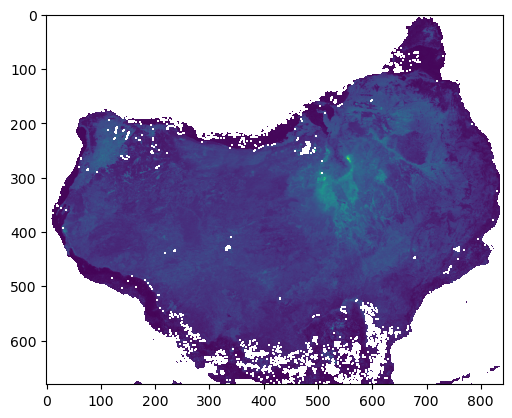

In [20]:
plt.imshow(np.nanmean(var,axis=0))

In [ ]:
var_gap_filled = gap_fill(var, window=30)

Before 1 693 [   nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
 9.e-06 9.e-06 9.e-06 9.e-06    nan    nan    nan    nan    nan    nan]
After 1 693 [9.e-06 9.e-06 9.e-06 9.e-06 9.e-06 9.e-06 9.e-06 9.e-06 9.e-06 9.e-06
 9.e-06 9.e-06 9.e-06 9.e-06 9.e-06 9.e-06 9.e-06 9.e-06 9.e-06 9.e-06
 9.e-06 9.e-06 9.e-06 9.e-06 9.e-06 9.e-06 9.e-06 9.e-06 9.e-06 9.e-06]
Before 1 700 [1.1e-05 1.1e-05 1.1e-05 1.1e-05 1.1e-05 1.1e-05 1.1e-05 1.1e-05     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan]
After 1 700 [1.1e-05 1.1e-05 1.1e-05 1.1e-05 1.1e-05 1.1e-05 1.1e-05 1.1e-05 1.1e-05
 1.1e-05 1.1e-05 1.1e-05 1.1e-05 1.1e-05 1.1e-05 1.1e-05 1.1e-05 1.1e-05
 1.1e-05 1.1e-05 1.1e-05 1.1e-05 1.1e-05 1.1e-05 1.1e-05 1.1e-05 1.1e-05
 1.1e-05 1.1e-05 1.1e-05]
Before 2 687 [1.e-05 1.e-05 1.e-

In [18]:
var_gap_filled.shape

(100, 681, 841)

In [15]:
var_plot = np.sum(~np.isnan(var_gap_filled),axis=0)/100*100.

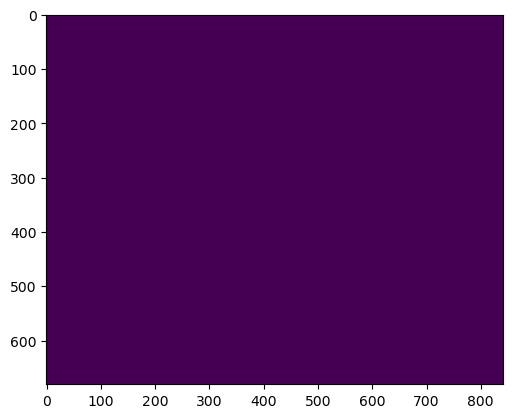

In [19]:
plt.imshow(var_plot)

In [63]:
ntime = var.shape[0]
nlat  = var.shape[1]
nlon  = var.shape[2]

In [64]:
var_plot = np.sum(~np.isnan(var),axis=0)/ntime*100.

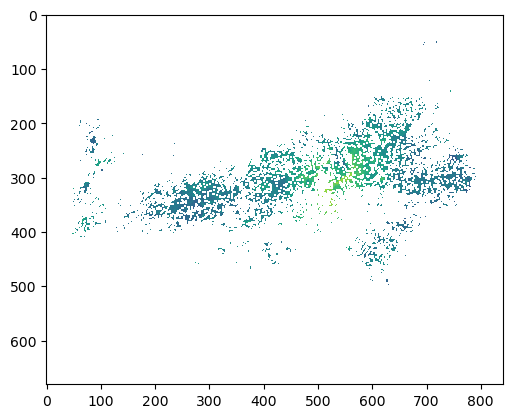

In [67]:
plt.imshow(np.mean(var,axis=0))

# Check missing value map

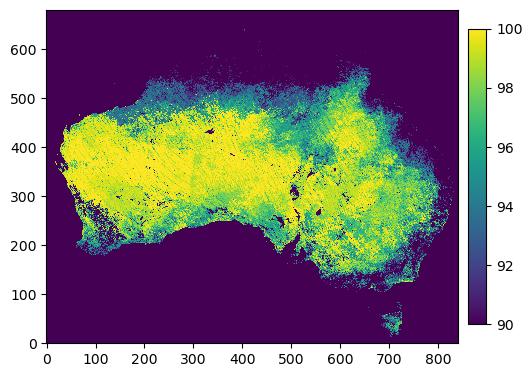

In [10]:
plt.imshow(var_plot, origin="lower", interpolation="none", vmin=90, vmax=100)
plt.colorbar(orientation="vertical", pad=0.02, aspect=16, shrink=0.8)

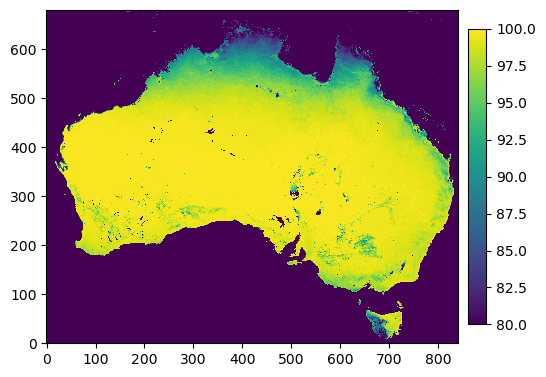

In [81]:
# plt.imshow(var_plot, origin="lower", interpolation="none", vmin=80, vmax=100)
# plt.colorbar(orientation="vertical", pad=0.02, aspect=16, shrink=0.8)

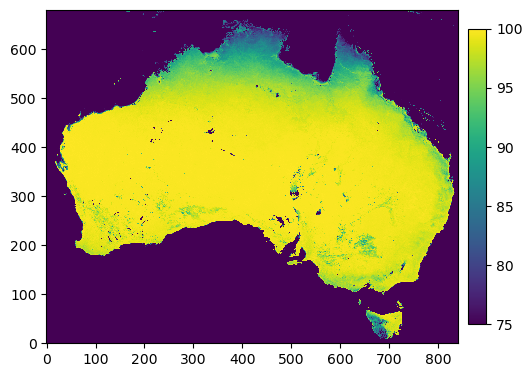

In [82]:
# plt.imshow(var_plot, origin="lower", interpolation="none", vmin=75, vmax=100)
# plt.colorbar(orientation="vertical", pad=0.02, aspect=16, shrink=0.8)

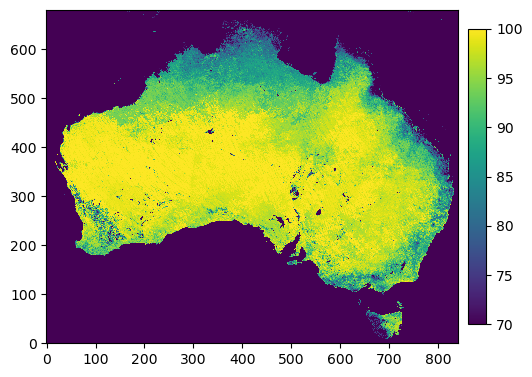

In [11]:
plt.imshow(var_plot, origin="lower", interpolation="none", vmin=70, vmax=100)
plt.colorbar(orientation="vertical", pad=0.02, aspect=16, shrink=0.8)

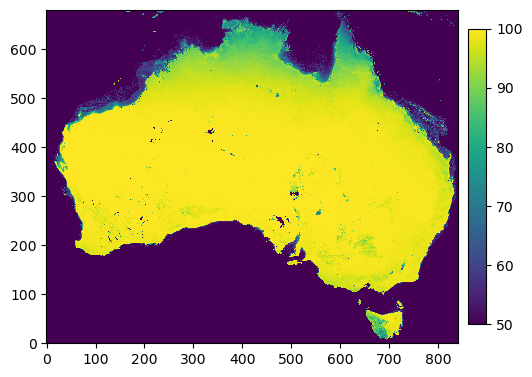

In [50]:
# plt.imshow(var_plot, origin="lower", interpolation="none", vmin=50, vmax=100)
# plt.colorbar(orientation="vertical", pad=0.02, aspect=16, shrink=0.8)

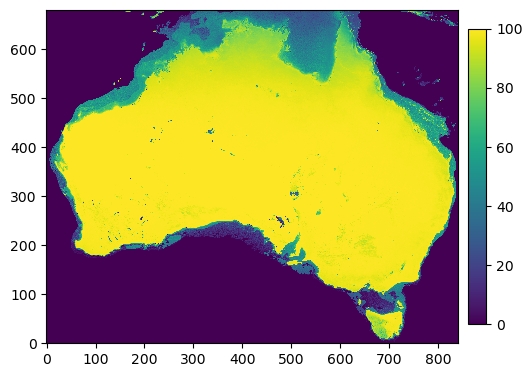

In [56]:
# plt.imshow(var_plot, origin="lower", interpolation="none", vmin=0, vmax=100)
# plt.colorbar(orientation="vertical", pad=0.02, aspect=16, shrink=0.8)

# Gap filling

In [55]:
def gap_fill(var, window=30):


    # Iterate over each lat-lon point
    for lat in np.arange(nlat):
        for lon in np.arange(nlon):

            # Extract the time series for the specific lat-lon point
            time_series = var[:, lat, lon]

            # Find indices where the value is NaN
            nan_indices   = np.where(np.isnan(time_series))[0]

            # Find the valid (non-NaN) indices within the 30-day window
            valid_indices = np.where(~np.isnan(time_series))[0]
            
            if len(valid_indices) > 2:

                for nan_index in nan_indices:

                    nan_date  = nan_index

                    # Compute the absolute distances between valid indices and the nan_index
                    distances      = np.abs(valid_indices - nan_date)
                    # print(nan_index,distances)

                    # Sort the valid indices by their distance from nan_index, 
                    # sorted_indices are indices for array distances, array distances and valid_indices have the same indices
                    sorted_indices = np.argsort(distances)
                    # print(nan_index,sorted_indices)


                    # the two closest dates are within one window distance from the date with nan, 
                    # and the two closest dates are within one window distance
                    # _index are indices for array distances and valid_indices
                    # _date are indices for array time_series
                    closest_first_index  = sorted_indices[0]
                    closest_first_date   = valid_indices[sorted_indices[0]]
                    closest_second_index = sorted_indices[1]
                    closest_second_date  = valid_indices[sorted_indices[1]]

                    # if 2nd and 3rd closest dates are the same distance to the nan date
                    if distances[closest_second_index] == distances[closest_first_index]:
                        if_same_side     = (closest_first_date - nan_date)*(closest_second_date - nan_date)>0
                        if if_same_side:
                            closest_second_index = sorted_indices[2]
                            closest_second_date  = valid_indices[sorted_indices[2]]


                    # the closest two dates are within the time window
                    if distances[closest_second_index] <= window and abs(closest_second_date-closest_first_date) <= window:

                        # print(nan_date, closest_first_date, closest_second_date)
                        # Linear interpolation formula
                        delta                 = (time_series[closest_second_date] - time_series[closest_first_date])/ (closest_second_date - closest_first_date)
                        time_series[nan_date] = time_series[closest_first_date] + delta * (nan_date - closest_first_date) 
                        # print(time_series[nan_date], delta, delta * (nan_date - closest_first_date) , time_series[closest_first_date], time_series[closest_second_date])

                    else:
                        continue
                var[:, lat, lon] = time_series
            else:
                var[:, lat, lon] = np.nan


In [56]:
result = gap_fill(var, window=30)

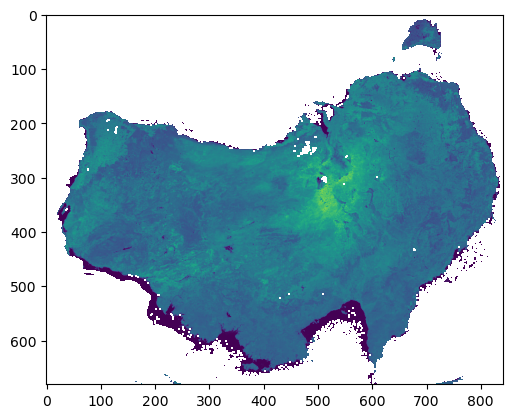

In [58]:
plt.imshow(np.mean(result, axis=0))

In [72]:
def fill_gap_for_point(args):
    
    var, lat, lon, window = args
    
    time_series = var[:, lat, lon]
    nan_indices = np.where(np.isnan(time_series))[0]

    if len(nan_indices) == 0:
        return time_series

    valid_indices = np.where(~np.isnan(time_series))[0]

    if len(valid_indices) <= 2:
        return time_series

    for nan_index in nan_indices:
        distances = np.abs(valid_indices - nan_index)
        sorted_indices = np.argsort(distances)

        closest_first_date = valid_indices[sorted_indices[0]]
        closest_second_date = valid_indices[sorted_indices[1]]

        if distances[sorted_indices[1]] == distances[sorted_indices[0]]:
            if_same_side = (closest_first_date - nan_index) * (closest_second_date - nan_index) > 0
            if if_same_side:
                closest_second_date = valid_indices[sorted_indices[2]]

        if (distances[sorted_indices[1]] <= window and 
            abs(closest_second_date - closest_first_date) <= window):

            delta = (time_series[closest_second_date] - time_series[closest_first_date]) / \
                    (closest_second_date - closest_first_date)
            time_series[nan_index] = time_series[closest_first_date] + delta * (nan_index - closest_first_date)

    return time_series

In [73]:
def gap_fill(var, window=30):
    nlat, nlon = var.shape[1], var.shape[2]
    
    # Create the argument list for each process
    args = [(var, lat, lon, window) for lat in range(nlat) for lon in range(nlon)]
    
    # Use multiprocessing to parallelize the task
    with Pool(processes=cpu_count()) as pool:
        results = pool.map(fill_gap_for_point, args)

    # Reassemble the results back into the original array shape
    for i, (lat, lon) in enumerate([(lat, lon) for lat in range(nlat) for lon in range(nlon)]):
        var[:, lat, lon] = results[i]

    return var

In [86]:
var_gap_filled = gap_fill(var, window=90)

In [87]:
var_plot       = np.sum(~np.isnan(var_gap_filled),axis=0)/ntime*100.

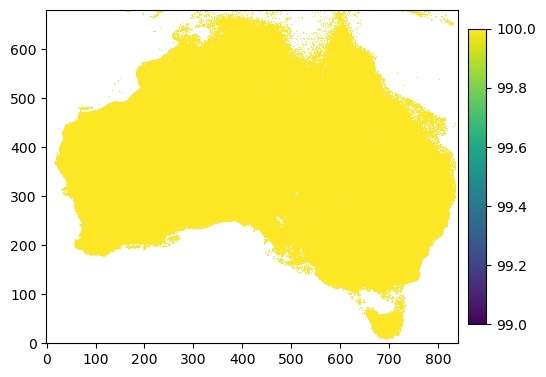

In [88]:
plt.imshow(np.where(var_plot>99,var_plot,np.nan), origin="lower", interpolation="none", vmin=99, vmax=100)
plt.colorbar(orientation="vertical", pad=0.02, aspect=16, shrink=0.8)

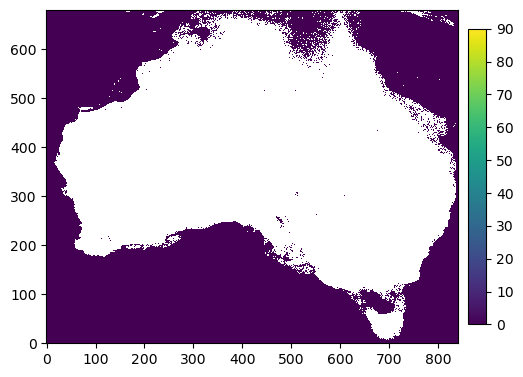

In [89]:
plt.imshow(np.where(var_plot<99,var_plot,np.nan), origin="lower", interpolation="none", vmin=0, vmax=90)
plt.colorbar(orientation="vertical", pad=0.02, aspect=16, shrink=0.8)

# Check gap filled data 

In [14]:
albedo_band   = "BSA_nir"
var_name      = "Albedo_"+albedo_band

scale_factor  = 0.001
missing_value = 32767

AWAP_5km_path = "/g/data/w97/mm3972/data/MODIS/MODIS_Albedo/AUS/regrid_2_AWAP_5km_daily/MCD43A3.061_500m_aid0001_BSA_nir_2000-2024_albedo_regridded_daily.nc"

f_check_download = nc.Dataset(AWAP_5km_path,'r')
var_download     = f_check_download.variables[var_name][:,:,:]
var_download     = np.where(var_download > 1.0, np.nan, var_download)
var_download     = np.where(var_download < 0, np.nan, var_download)
var_download_mean= np.mean(var_download,axis=0)

In [15]:
ntime = var_download.shape[0]

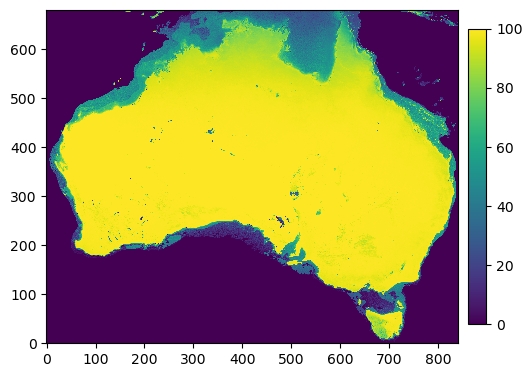

In [16]:
var_plot       = np.sum(~np.isnan(var_download),axis=0)/ntime*100.
plt.imshow(var_plot, origin="lower", interpolation="none", vmin=0, vmax=100)
plt.colorbar(orientation="vertical", pad=0.02, aspect=16, shrink=0.8)

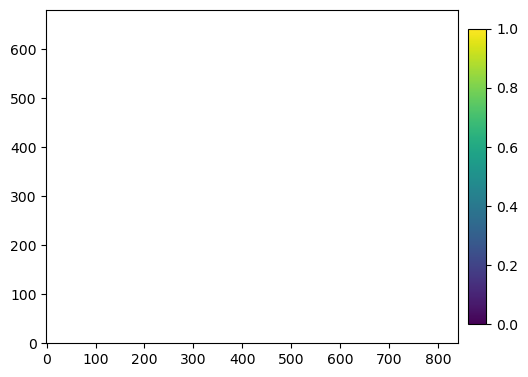

In [28]:
plt.imshow(np.mean(var_download,axis=0), origin="lower", interpolation="none", vmin=0, vmax=1)
plt.colorbar(orientation="vertical", pad=0.02, aspect=16, shrink=0.8)

In [ ]:
AWAP_5km_path = "/g/data/w97/mm3972/data/MODIS/MODIS_Albedo/AUS/WSA_nir/MCD43A3.061_500m_aid0001_WSA_nir_2003.nc"

f_check_download1 = nc.Dataset(AWAP_5km_path,'r')
var_download1     = f_check_download1.variables['Albedo_WSA_nir'][:,:,:]
var_download1     = np.where(var_download1 > 1.0, np.nan, var_download1)
var_download1     = np.where(var_download1 < 0, np.nan, var_download1)
var_download_mean1= np.mean(var_download1,axis=0)

In [ ]:
plt.imshow(var_download_mean1, origin="lower", interpolation="none", vmin=0, vmax=1.)
plt.colorbar(orientation="vertical", pad=0.02, aspect=16, shrink=0.8)

In [9]:
AWAP_5km_path = "/g/data/w97/mm3972/data/MODIS/MODIS_Albedo/AUS/regrid_2_AWAP_5km_daily/MCD43A3.061_500m_aid0001_WSA_nir_Dec2002-Jan2004_albedo_regridded_daily.nc"

f_check_download1 = nc.Dataset(AWAP_5km_path,'r')
var_download1     = f_check_download1.variables['Albedo_WSA_nir'][:,:,:]
var_download1     = np.where(var_download1 > 1.0, np.nan, var_download1)
var_download1     = np.where(var_download1 < 0, np.nan, var_download1)
var_download_mean1= np.mean(var_download1,axis=0)

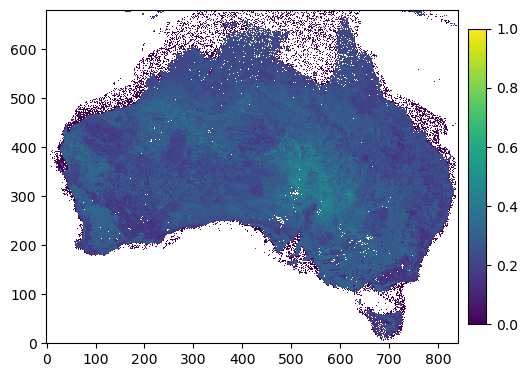

In [10]:
plt.imshow(var_download_mean1, origin="lower", interpolation="none", vmin=0, vmax=1.)
plt.colorbar(orientation="vertical", pad=0.02, aspect=16, shrink=0.8)

In [15]:
AWAP_5km_path = "/g/data/w97/mm3972/data/MODIS/MODIS_Albedo/AUS/regrid_2_AWAP_5km_daily/MCD43A3.061_500m_aid0001_WSA_nir_Dec2002-2003_albedo_regridded_daily_gapfill.nc"

f_check_download1 = nc.Dataset(AWAP_5km_path,'r')
var_download1     = f_check_download1.variables['Albedo_WSA_nir'][:,:,:]
var_download1     = np.where(var_download1 > 1.0, np.nan, var_download1)
var_download1     = np.where(var_download1 < 0, np.nan, var_download1)
var_download_mean1= np.mean(var_download1,axis=0)

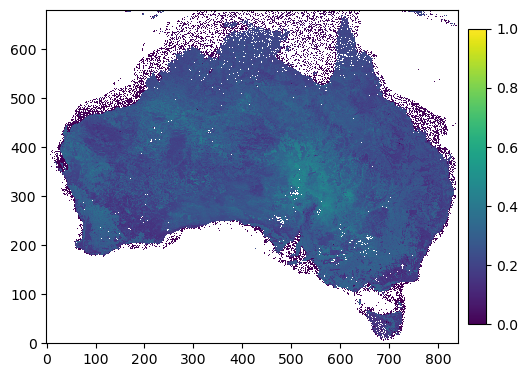

In [16]:
plt.imshow(var_download_mean1, origin="lower", interpolation="none", vmin=0, vmax=1.)
plt.colorbar(orientation="vertical", pad=0.02, aspect=16, shrink=0.8)

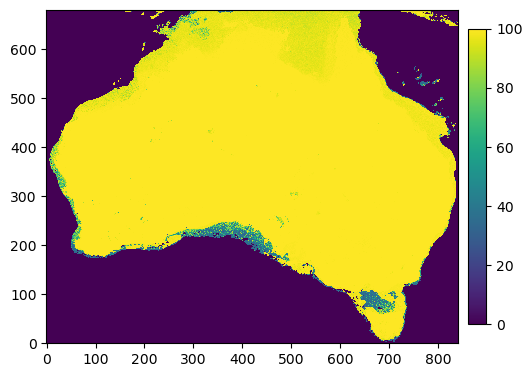

In [31]:
ntime1 = var_download1.shape[0]
var_plot1       = np.sum(~np.isnan(var_download1),axis=0)/ntime1*100.
plt.imshow(var_plot1, origin="lower", interpolation="none", vmin=0, vmax=100)
plt.colorbar(orientation="vertical", pad=0.02, aspect=16, shrink=0.8)

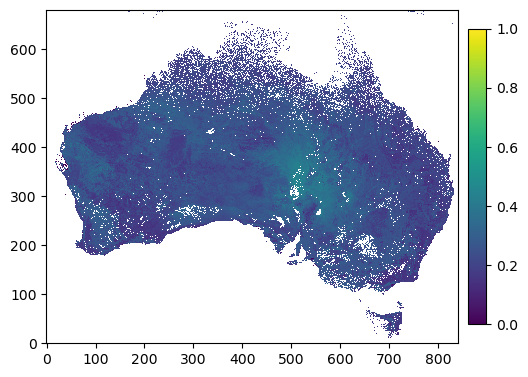

In [27]:
plt.imshow(np.mean(var_download1,axis=0), origin="lower", interpolation="none", vmin=0, vmax=1)
plt.colorbar(orientation="vertical", pad=0.02, aspect=16, shrink=0.8)

In [5]:
AWAP_5km_path = "/g/data/w97/mm3972/data/MODIS/MODIS_Albedo/AUS/regrid_2_AWAP_5km_climatology/MCD43A3.061_2003-2023_BSA_nir_climatology_common.nc"

f_check_download1 = nc.Dataset(AWAP_5km_path,'r')
var_download1     = f_check_download1.variables['albedo'][:,:,:]
var_download1     = np.where(var_download1 > 1.0, np.nan, var_download1)
var_download1     = np.where(var_download1 < 0, np.nan, var_download1)
var_download_mean1= np.mean(var_download1,axis=0)

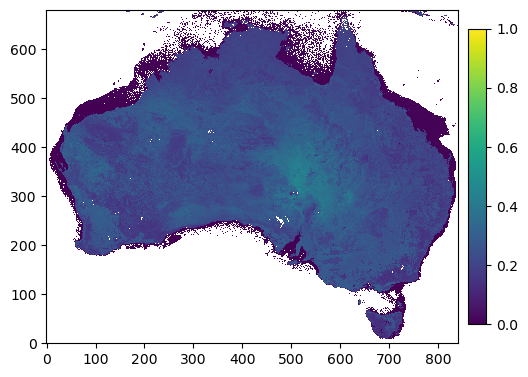

In [6]:
plt.imshow(np.mean(var_download1,axis=0), origin="lower", interpolation="none", vmin=0, vmax=1)
plt.colorbar(orientation="vertical", pad=0.02, aspect=16, shrink=0.8)

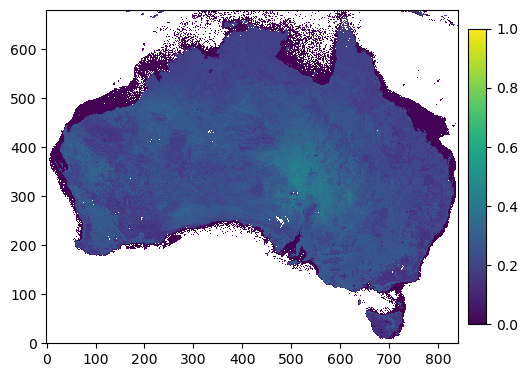

In [7]:
AWAP_5km_path = "/g/data/w97/mm3972/data/MODIS/MODIS_Albedo/AUS/regrid_2_AWAP_5km_climatology/MCD43A3.061_2003-2023_BSA_nir_climatology_leap.nc"

f_check_download1 = nc.Dataset(AWAP_5km_path,'r')
var_download1     = f_check_download1.variables['albedo'][:,:,:]
var_download1     = np.where(var_download1 > 1.0, np.nan, var_download1)
var_download1     = np.where(var_download1 < 0, np.nan, var_download1)
var_download_mean1= np.mean(var_download1,axis=0)

plt.imshow(np.mean(var_download1,axis=0), origin="lower", interpolation="none", vmin=0, vmax=1)
plt.colorbar(orientation="vertical", pad=0.02, aspect=16, shrink=0.8)

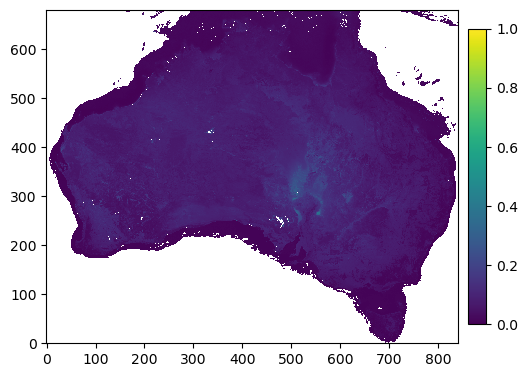

In [14]:
AWAP_5km_path = "/g/data/w97/mm3972/data/MODIS/MODIS_Albedo/AUS/regrid_2_AWAP_5km_climatology/MCD43A3.061_2003-2023_BSA_vis_climatology_leap.nc"

f_check_download1 = nc.Dataset(AWAP_5km_path,'r')
var_download1     = f_check_download1.variables['albedo'][:,:,:]
var_download1     = np.where(var_download1 > 1.0, np.nan, var_download1)
var_download1     = np.where(var_download1 < 0, np.nan, var_download1)
var_download_mean1= np.mean(var_download1,axis=0)

plt.imshow(np.mean(var_download1,axis=0), origin="lower", interpolation="none", vmin=0, vmax=1)
plt.colorbar(orientation="vertical", pad=0.02, aspect=16, shrink=0.8)

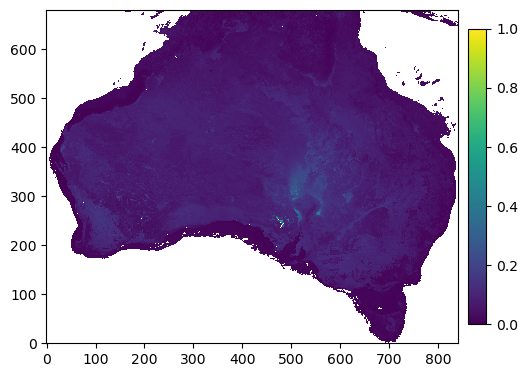

In [17]:
plt.imshow(var_download1[10,:,:], origin="lower", interpolation="none", vmin=0, vmax=1)
plt.colorbar(orientation="vertical", pad=0.02, aspect=16, shrink=0.8)

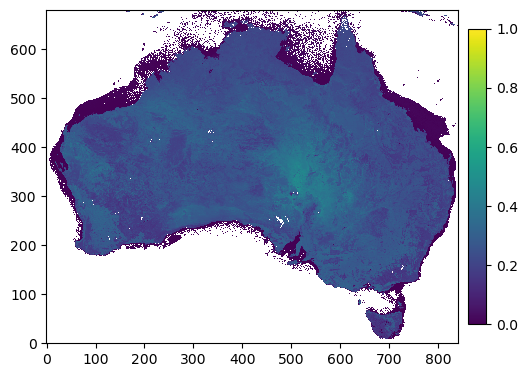

In [11]:
AWAP_5km_path = "/g/data/w97/mm3972/data/MODIS/MODIS_Albedo/AUS/regrid_2_AWAP_5km_climatology/MCD43A3.061_2003-2023_WSA_nir_climatology_leap.nc"

f_check_download1 = nc.Dataset(AWAP_5km_path,'r')
var_download1     = f_check_download1.variables['albedo'][:,:,:]
var_download1     = np.where(var_download1 > 1.0, np.nan, var_download1)
var_download1     = np.where(var_download1 < 0, np.nan, var_download1)
var_download_mean1= np.mean(var_download1,axis=0)

plt.imshow(np.mean(var_download1,axis=0), origin="lower", interpolation="none", vmin=0, vmax=1)
plt.colorbar(orientation="vertical", pad=0.02, aspect=16, shrink=0.8)

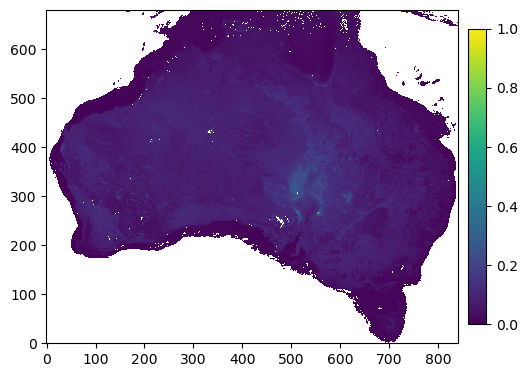

In [10]:
AWAP_5km_path = "/g/data/w97/mm3972/data/MODIS/MODIS_Albedo/AUS/regrid_2_AWAP_5km_climatology/MCD43A3.061_2003-2023_WSA_vis_climatology_leap.nc"

f_check_download1 = nc.Dataset(AWAP_5km_path,'r')
var_download1     = f_check_download1.variables['albedo'][:,:,:]
var_download1     = np.where(var_download1 > 1.0, np.nan, var_download1)
var_download1     = np.where(var_download1 < 0, np.nan, var_download1)
var_download_mean1= np.mean(var_download1,axis=0)

plt.imshow(np.mean(var_download1,axis=0), origin="lower", interpolation="none", vmin=0, vmax=1)
plt.colorbar(orientation="vertical", pad=0.02, aspect=16, shrink=0.8)

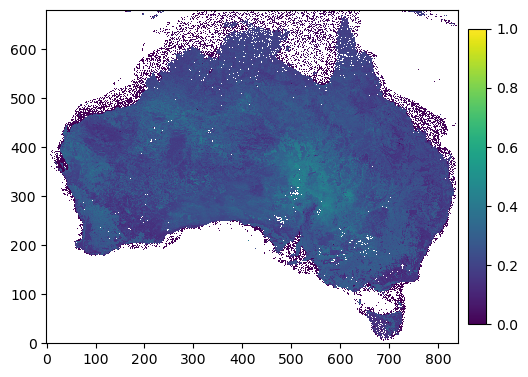

In [13]:
AWAP_5km_path = "/g/data/w97/mm3972/data/MODIS/MODIS_Albedo/AUS/regrid_2_AWAP_5km_daily/MCD43A3.061_500m_aid0001_BSA_nir_Dec2002-2003_albedo_regridded_daily_gapfill_backup.nc"

f_check_download1 = nc.Dataset(AWAP_5km_path,'r')
var_download1     = f_check_download1.variables['Albedo_BSA_nir'][:,:,:]
var_download1     = np.where(var_download1 > 1.0, np.nan, var_download1)
var_download1     = np.where(var_download1 < 0, np.nan, var_download1)
var_download_mean1= np.mean(var_download1,axis=0)

plt.imshow(np.mean(var_download1,axis=0), origin="lower", interpolation="none", vmin=0, vmax=1)
plt.colorbar(orientation="vertical", pad=0.02, aspect=16, shrink=0.8)

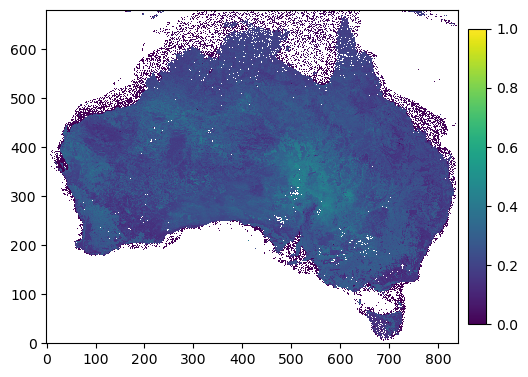

In [18]:
AWAP_5km_path = "/g/data/w97/mm3972/data/MODIS/MODIS_Albedo/AUS/regrid_2_AWAP_5km_daily/MCD43A3.061_500m_aid0001_BSA_nir_Dec2002-2003_albedo_regridded_daily_gapfill.nc"

f_check_download1 = nc.Dataset(AWAP_5km_path,'r')
var_download1     = f_check_download1.variables['Albedo_BSA_nir'][:,:,:]
var_download1     = np.where(var_download1 > 1.0, np.nan, var_download1)
var_download1     = np.where(var_download1 < 0, np.nan, var_download1)
var_download_mean1= np.mean(var_download1,axis=0)

plt.imshow(np.mean(var_download1,axis=0), origin="lower", interpolation="none", vmin=0, vmax=1)
plt.colorbar(orientation="vertical", pad=0.02, aspect=16, shrink=0.8)


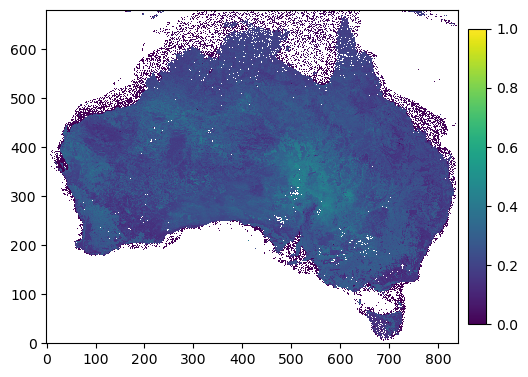

In [19]:
AWAP_5km_path = "/g/data/w97/mm3972/data/MODIS/MODIS_Albedo/AUS/regrid_2_AWAP_5km_daily/MCD43A3.061_500m_aid0001_BSA_nir_Dec2002-2003_albedo_regridded_daily_gapfill_backup.nc"

f_check_download1 = nc.Dataset(AWAP_5km_path,'r')
var_download1     = f_check_download1.variables['Albedo_BSA_nir'][:,:,:]
var_download1     = np.where(var_download1 > 1.0, np.nan, var_download1)
var_download1     = np.where(var_download1 < 0, np.nan, var_download1)

plt.imshow(np.mean(var_download1,axis=0), origin="lower", interpolation="none", vmin=0, vmax=1)
plt.colorbar(orientation="vertical", pad=0.02, aspect=16, shrink=0.8)


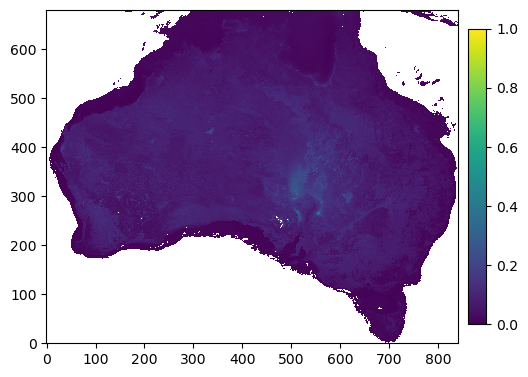

In [10]:
AWAP_5km_path = "/g/data/w97/mm3972/data/MODIS/MODIS_Albedo/AUS/regrid_2_AWAP_5km_climatology/MCD43A3.061_2003-2023_BSA_vis_climatology_common.nc"

f_check_download1 = nc.Dataset(AWAP_5km_path,'r')
var_download1     = f_check_download1.variables['Albedo_BSA_vis'][:,:,:]
var_download1     = np.where(var_download1 > 1.0, np.nan, var_download1)
var_download1     = np.where(var_download1 < 0, np.nan, var_download1)

plt.imshow(np.mean(var_download1,axis=0), origin="lower", interpolation="none", vmin=0, vmax=1)
plt.colorbar(orientation="vertical", pad=0.02, aspect=16, shrink=0.8)


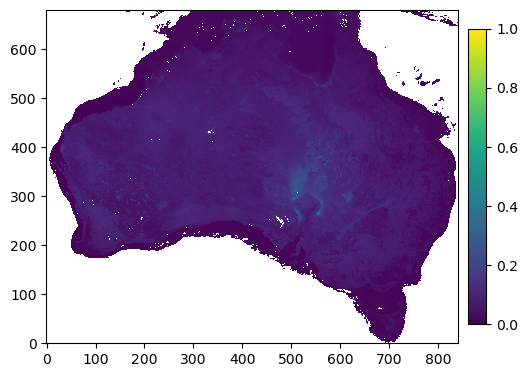

In [11]:
AWAP_5km_path = "/g/data/w97/mm3972/data/MODIS/MODIS_Albedo/AUS/regrid_2_AWAP_5km_climatology/MCD43A3.061_500m_aid0001_BSA_vis_2003-2023_climatology_common.nc"

f_check_download1 = nc.Dataset(AWAP_5km_path,'r')
var_download1     = f_check_download1.variables['Albedo_BSA_vis'][:,:,:]
var_download1     = np.where(var_download1 > 1.0, np.nan, var_download1)
var_download1     = np.where(var_download1 < 0, np.nan, var_download1)

plt.imshow(np.mean(var_download1,axis=0), origin="lower", interpolation="none", vmin=0, vmax=1)
plt.colorbar(orientation="vertical", pad=0.02, aspect=16, shrink=0.8)
